<a href="https://colab.research.google.com/github/GaoDongWan/Reinforcement_Learning/blob/master/actor_critic/SAC_discrete_TF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **装载云盘**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


### **安装tensorflow 2.0**

In [2]:
!pip install tensorflow-gpu==2.0.0-beta1 

     |████████████████████████████████| 348.9MB 89kB/s 
     |████████████████████████████████| 501kB 37.0MB/s 
     |████████████████████████████████| 3.1MB 38.3MB/s 


In [3]:
# tensorlayer 兼容问题
!pip install imgaug==0.2.6

     |████████████████████████████████| 634kB 3.4MB/s 
  Created wheel for imgaug: filename=imgaug-0.2.6-cp36-none-any.whl size=654020 sha256=4a6e30cba0a11cef44c4c100cb8d30c6d9050e53a7bfe1d077911a1b2f09b61d
  Stored in directory: /root/.cache/pip/wheels/97/ec/48/0d25896c417b715af6236dbcef8f0bed136a1a5e52972fc6d0
Successfully built imgaug
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9


In [4]:
!pip install tensorlayer

     |████████████████████████████████| 358kB 3.4MB/s 
     |████████████████████████████████| 6.6MB 28kB/s 
     |████████████████████████████████| 2.9MB 34.6MB/s 
     |████████████████████████████████| 24.8MB 31.5MB/s 
     |████████████████████████████████| 3.3MB 34.2MB/s 
  Created wheel for wrapt: filename=wrapt-1.11.1-cp36-cp36m-linux_x86_64.whl size=67443 sha256=3e7c210cc8ac7f51a9ea86f5567d84127c9d944a19fa5f2e96756a669d765139
  Stored in directory: /root/.cache/pip/wheels/89/67/41/63cbf0f6ac0a6156588b9587be4db5565f8c6d8ccef98202fc
Successfully built wrapt
  Found existing installation: scipy 1.3.1
    Uninstalling scipy-1.3.1:
      Successfully uninstalled scipy-1.3.1
  Found existing installation: scikit-learn 0.21.3
    Uninstalling scikit-learn-0.21.3:
      Successfully uninstalled scikit-learn-0.21.3
  Found existing installation: progressbar2 3.38.0
    Uninstalling progressbar2-3.38.0:
      Successfully uninstalled progressbar2-3.38.0
  Found existing installation: h5p

### **cd命令**

In [0]:
import os
os.chdir("drive/My Drive/RL_EA/Actor_Critic")

### **查看当前路径**

In [6]:
!pwd

/content/drive/My Drive/RL_EA/Actor_Critic


# Soft Actor Critic (SAC)

</br>
$$
off-Policy\\
continous\ \&\ disvrete
$$
</br>
*这里是discrete的代码。按照SAC论文公式调整了一部分代码。

</br>

</br>

**核心思想是通过利用最大熵学习来让策略多元化**


<table>
<tbody>
<tr>
<td>
<center>
<img src="https://bair.berkeley.edu/static/blog/softq/figure_3a_unimodal-policy.png" width="80%" height="80%" />

传统RL
</center>
</td>
<td>
<center>
<img src="https://bair.berkeley.edu/static/blog/softq/figure_3b_multimodal_policy.png" width="80%" height="80%" />

多模RL
</center>
</td>
</tr>
</tbody>
</table>

**信息熵定义：**
$$
H(P)=\underset{x \sim P}{\mathrm E}\big[-logP(x) \big]
$$

**最大熵RL：**
$$
\pi^*=\arg\max_{\pi}\mathbb{E}_{(s_t,a_t)\sim \rho_\pi}[\sum_{t}{\underbrace{R(s_t,a_t)}_{reward}} +\alpha\underbrace{ H(\pi(\cdot|s_t))}_{entropy}]
$$
</br>
*  **SAC中的Q，V：**

$$
Q(s_t,a_t)=r(s_t,a_t)+\gamma\mathbb{E}_{s_{t+1}\ \sim\rho}[V(s_{t+1})]
$$
</br>
$$
V(s_t)=\mathbb{E}_{a_t\sim\pi}[Q(s_t,a_t)-\alpha \log \pi(a_t|s_t)]
$$
</br>
$$
Q(s_t,a_t)=r(s_t,a_t) + \gamma\mathbb{E}_{s_{t+1}\ \ ,\ a_{t+1}}\ [Q(s_{t+1},a_{t+1})-\alpha \log(\pi(a_{t+1}|s_{t+1}))]
$$
</br>
*  **SAC中的policy：**
</br>

> 作者认为让$\pi$服从玻尔兹曼分布能使其达成图2的效果：

$$
\pi(a_t|s_t)\propto exp(-\mathcal{E}(s_t,a_t))
$$

> 之后将分布与Q联系起来:

$$
\mathcal{E}(s_t,a_t)=-\frac{1}{\alpha}Q(s_t,a_t)
$$

> 得到（$\alpha$相当于温度系数）：

$$
\pi(a_t|s_t)\propto exp(Q(s_t,a_t))
$$

> 由此作者提出：

$$
\pi'=\arg \min_{\pi_{k}\ \in\Pi}D_{KL}(\pi_k(\cdot|s_t)||\frac{\exp(\frac{1}{\alpha}Q^{\pi}(s_t,\cdot))}{Z^{\pi}(s_t)})
$$

**Policy更新方式：**

$$
\begin{equation} \begin{split} J_\pi(\phi) &= D_\text{KL} \big( \pi_\phi(. \vert s_t) \| \exp(\frac{1}{\alpha}Q_\theta(s_t, .) - \log Z(s_t)) \big) \\ &= \mathbb{E}_{s_t\sim\mathcal{D},a_t\sim \pi_\phi} \Big[ \log \big( \frac{\pi_\phi(a_t \vert s_t)}{\exp(\frac{1}{\alpha}Q_\theta(s_t, a_t) - \log Z(s_t))} \big) \Big] \\\ &= \mathbb{E}_{s_t\sim\mathcal{D},a_t\sim \pi_\phi} [ \log \pi_\phi(a_t \vert s_t) -\frac{1}{\alpha} Q_\theta(s_t, a_t) + \log Z(s_t) ] \end{split} \end{equation}
$$

这里的$Z$是配分函数，在计算梯度中没有其它作用，可以忽略掉。

**动作选择：**

由于直接sample不能计算梯度，因此用到了reparameterization trick。

$$\mathbf{u}_t =\mu_t + \varepsilon_t \odot \sigma_t$$

$$a_t = \tanh (\mathbf{u})$$

此外，由于输出的continous的act值域太大，而具体的env的act维度往往在一个范围内，因此用tanh对act进行约束，这样又改变了分布，影响log似然的计算，作者给出了一个计算方式：

$$
\log \pi(a|s)=\log \mu(\mathbf{u}|s)-\sum_{i=1}^{D}{\log(1-\tanh^2(u_i))}
$$

**第一个版本的SAC除了Q和policy外，还用V来提高训练稳定性；而新版本（本文）的SAC直接用Q，policy，并加上了自动调整的$\alpha$。**

自适应α就是将最大化reward的问题加了一个约束：

$$
\max_{\pi_0, \dots, \pi_T} \mathbb{E} \Big[ \sum_{t=0}^T r(s_t, a_t)\Big] \text{s.t. } \forall t\text{, } \mathcal{H}(\pi_t) \geq \mathcal{H}_0
$$

再通过拉格朗日对偶的思想，得到阿尔法的更新方式：

$$
J(\alpha) = \mathbb{E}_{a_t \sim \pi_t} [-\alpha \log \pi_t(a_t\mid\pi_t) - \alpha \mathcal{H}_0]
$$

原文设置$\mathcal{H}_0=-\dim(\mathcal{A})$

**总结一下新版SAC的学习方式（Q：$\theta$，$\pi$：$\phi$，$\alpha$）：**

1.   Q（类似TD3，用到了两组Q网络，选min）：

$$
Q'(s_t,a_t)=r(s_t,a_t) + \gamma\mathbb{E}_{s_{t+1}\ \ ,\ a_{t+1}}\ \big[\min_{i}Q_{\theta_{targ,i}}\ \ (s_{t+1},a_{t+1})-\alpha \log(\pi_{\phi}(a_{t+1}|s_{t+1}))\big]
$$

$$
 \begin{split} J_Q(\theta)&=\mathbb{E}_{(s_t,a_t,s_{t+1}\ )\sim \mathcal{D},a_{t+1}\ \sim\pi_{\phi}}[\frac{1}{2}(Q_{\theta_i}(s_t,a_t) - Q'(s_t,a_t))^2]  \end{split} 
$$

2.   action选择（$\mu_t，\sigma_t$由actor得到，$\varepsilon_t$由固定的分布[比如高斯]随机采样得到）,这份代码在log$\pi$后面加了个正则项：

$$\mathbf{u}_t =\mu_t + \varepsilon_t \odot \sigma_t$$

$$a_t = \tanh (\mathbf{u})$$

$$
\log \pi(a|s)=\log \mu(\mathbf{u}|s)-\sum_{i=1}^{D}{\log(1-\tanh^2(u_i))}
$$

3.   Policy：

$$
J_\pi(\phi)=\mathbb{E}_{s_t\sim\mathcal{D},a_t\sim \pi_\phi} [\alpha \log \pi_\phi(a_t \vert s_t) - Q_\theta(s_t, a_t) ]
$$

4.   $\alpha$：

$$
J(\alpha) = -\mathbb{E}_{a_t \sim \pi_t} [\alpha (\log \pi_t(a_t\mid\pi_t) +  \mathcal{H}_0)]
$$

**原文及代码使用的高斯分布去近似玻尔兹曼分布，所以实际上SAC并不是像图2那样是严格多模的。**

In [0]:
import math
import time
import random

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output

import gym
import tensorflow as tf
import tensorflow_probability as tfp
import tensorlayer as tl
from tensorlayer.layers import Dense
from tensorlayer.models import Model

In [0]:
tfp = tfp.distributions
Normal = tfp.Normal
Categorical = tfp.Categorical
tl.logging.set_verbosity(tl.logging.DEBUG)

random.seed(11)
np.random.seed(11)
tf.random.set_seed(11)

##### hyper parameters #####

ENV = 'CartPole-v0'
action_range = 1.
max_frames = 601
test_frames = 30
max_steps = 150
batch_size = 64
explore_steps = 50
update_itr = 1
hidden_dim = 32
soft_q_lr = 3e-4
policy_lr = 3e-4
alpha_lr = 3e-4
reward_scale = 1.
replay_buffer_size = 10000

AUTO_ENTROPY = True
DETERMINISTIC = False

In [0]:
# buffer
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.position = 0

    def push(self, state, action, reward, next_state, done):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = (state, action, reward, next_state, done)
        self.position = int((self.position + 1) % self.capacity)

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = map(np.stack, zip(*batch))
        '''
        * : sum(a,b) <=> batch=(a,b), sum(*batch)
        zip : a=[1,2], b=[2,3], zip(a,b) => [(1,2),(2,3)]
        map : map(square, [2,3]) => [4,9]
        stack : np.stack((1,2)) => array([1,2])
        '''
        return state, action, reward, next_state, done

    def __len__(self):
        return len(self.buffer)


In [0]:
# utils
class NormalizedActions(gym.ActionWrapper):

    def action(self, action):
        low = self.action_space.low
        high = self.action_space.high

        action = low + (action + 1.0) * 0.5 * (high - low)  # ?
        action = np.clip(action, low, high)
        return action

    def reverse_action(self, action):
        low = self.action_space.low
        high = self.action_space.high

        action = 2 * (action - low) / (high - low) - 1
        action = np.clip(action, low, high)
        return action

def plot(frame_idx, rewards):
    clear_output(True)
    plt.figure(figsize=(8, 5))
    plt.title('frame %s. reward:%s' % (frame_idx, rewards[-1]))
    plt.plot(rewards)
    plt.xlabel('Episode')
    plt.ylabel('Episode Reward')
    plt.savefig('sac.png')
    plt.show()

In [0]:
# Network
class SoftQNetwork(Model):

    def __init__(self, num_inputs, hidden_dim):
        super(SoftQNetwork, self).__init__()
        input_dim = num_inputs
        w_init = tf.keras.initializers.glorot_normal(seed=None)

        self.linear1 = Dense(n_units=hidden_dim, act=tf.nn.relu, W_init=w_init, in_channels=input_dim, name='q1')
        self.linear2 = Dense(n_units=hidden_dim, act=tf.nn.relu, W_init=w_init, in_channels=hidden_dim, name='q2')
        self.linear3 = Dense(n_units=2, W_init=w_init, in_channels=hidden_dim, name='q3')

    def forward(self, input):
        x = self.linear1(input)
        x = self.linear2(x)
        x = self.linear3(x)
        return x

class PolicyNetwork(Model):

    def __init__(self, num_inputs, hidden_dim, init_w=3e-3):
        super(PolicyNetwork, self).__init__()
        w_init = tf.random_uniform_initializer(-init_w, init_w)
        self.linear1 = Dense(n_units=hidden_dim, act=tf.nn.relu, W_init=w_init, in_channels=num_inputs,
                             name='policy1')
        self.linear2 = Dense(n_units=hidden_dim, act=tf.nn.relu, W_init=w_init, in_channels=hidden_dim,
                             name='policy2')
        self.linear3 = Dense(n_units=hidden_dim, act=tf.nn.relu, W_init=w_init, in_channels=hidden_dim,
                             name='policy3')

        self.act_prob = Dense(2, act=tf.nn.softmax, W_init=w_init,
                              b_init=tf.random_normal_initializer(-init_w, init_w), in_channels=hidden_dim,
                              name='act_prob')

    def forward(self, state):
        x = self.linear1(state)
        x = self.linear2(x)
        x = self.linear3(x)

        act_prob = self.act_prob(x)

        return act_prob

    def evaluate(self, state):
        state = state.astype(np.float32)
        action_prob = self.forward(state)
        action_distribution = Categorical(logits=action_prob)
        action = action_distribution.sample()
        z = action_prob == 0.0
        z = np.array(z).astype(np.float32) * 1e-8
        log_act_prob = tf.math.log(action_prob + z)

        return action, action_prob, log_act_prob, z

    def get_action(self, state):
        act_prob = self.forward([state])
        max_prob_act = tf.argmax(act_prob, axis=1)
        return np.array(max_prob_act[0])

    def sample_action(self, ):
        a = random.randint(0, 1)

        return np.array(a)

In [0]:
# SAC
class SAC_Trainer:

    def __init__(
            self, replay_buffer, hidden_dim, soft_q_lr=3e-4, policy_lr=3e-4, alpha_lr=3e-4
    ):
        self.replay_buffer = replay_buffer

        self.soft_q_net1 = SoftQNetwork(state_dim, hidden_dim)
        self.soft_q_net2 = SoftQNetwork(state_dim, hidden_dim)
        self.target_soft_q_net1 = SoftQNetwork(state_dim, hidden_dim)
        self.target_soft_q_net2 = SoftQNetwork(state_dim, hidden_dim)
        self.policy_net = PolicyNetwork(state_dim, hidden_dim)
        self.log_alpha = tf.Variable(0, dtype=np.float32, name='log_alpha')
        self.alpha = tf.math.exp(self.log_alpha)
        print('Q Network (1,2): ', self.soft_q_net1)
        print('Policy Network: ', self.policy_net)

        self.target_soft_q_net1 = self.target_ini(self.soft_q_net1, self.target_soft_q_net1)
        self.target_soft_q_net2 = self.target_ini(self.soft_q_net2, self.target_soft_q_net2)

        self.soft_q_optimizer1 = tf.optimizers.Adam(soft_q_lr)
        self.soft_q_optimizer2 = tf.optimizers.Adam(soft_q_lr)
        self.policy_optimizer = tf.optimizers.Adam(policy_lr)
        self.alpha_optimizer = tf.optimizers.Adam(alpha_lr)



    def target_ini(self, net, target_net):
        for target_param, param in zip(target_net.trainable_weights, net.trainable_weights):
            target_param.assign(param)
        return target_net

    def target_soft_update(self, net, target_net, soft_tau):
        for target_param, param in zip(target_net.trainable_weights, net.trainable_weights):
            target_param.assign(
                target_param * (1.0 - soft_tau) + param * soft_tau
            )
        return target_net

    def update(self, batch_size, auto_entropy=True, target_entropy=-2, gamma=0.99, soft_tau=1e-2):
        state, action, reward, next_state, done = self.replay_buffer.sample(batch_size)

        action = action[:, np.newaxis]
        reward = reward[:, np.newaxis]
        done = done[:, np.newaxis]

        # reward = reward_scale * (reward - np.mean(reward, axis=0)) / np.std(reward, axis=0)

        # Q func
        new_next_action, next_act_prob, next_log_prob, _ = self.policy_net.evaluate(next_state)
        target_q_input = next_state
        target_q_min = tf.minimum(self.target_soft_q_net1(target_q_input), self.target_soft_q_net2(target_q_input)) \
                       - self.alpha * next_log_prob
        # TODO mean是干什么的，不应该是sum吗？ 是sum了 ，只不过多除了个2。
        target_q_min = tf.reduce_mean(next_act_prob * target_q_min, axis=1, keepdims=True)
        target_q_value = reward + (1 - done) * gamma * target_q_min
        q_input = state

        with tf.GradientTape() as q1_tape:
            predicted_q_value1 = self.soft_q_net1(q_input)
            predicted_q_value1 = tf.reduce_sum(tf.squeeze(tf.one_hot(action, 2)) * predicted_q_value1, axis=1,
                                               keepdims=True)
            q_value_loss1 = tf.reduce_mean(tf.losses.mean_squared_error(predicted_q_value1, target_q_value))
        q1_grad = q1_tape.gradient(q_value_loss1, self.soft_q_net1.trainable_weights)
        self.soft_q_optimizer1.apply_gradients(zip(q1_grad, self.soft_q_net1.trainable_weights))

        with tf.GradientTape() as q2_tape:
            predicted_q_value2 = self.soft_q_net2(q_input)
            predicted_q_value2 = tf.reduce_sum(tf.squeeze(tf.one_hot(action, 2)) * predicted_q_value2, axis=1,
                                               keepdims=True)
            q_value_loss2 = tf.reduce_mean(tf.losses.mean_squared_error(predicted_q_value2, target_q_value))
        q2_grad = q2_tape.gradient(q_value_loss2, self.soft_q_net2.trainable_weights)
        self.soft_q_optimizer2.apply_gradients(zip(q2_grad, self.soft_q_net2.trainable_weights))

        # policy
        with tf.GradientTape() as p_tape:
            action, act_prob, log_prob, _ = self.policy_net.evaluate(state)
            q_input = state
            predicted_new_q_value = tf.minimum(self.soft_q_net1(q_input), self.soft_q_net2(q_input))
            policy_loss = tf.reduce_mean(act_prob * (self.alpha * log_prob - predicted_new_q_value))
        p_grad = p_tape.gradient(policy_loss, self.policy_net.trainable_weights)
        self.policy_optimizer.apply_gradients(zip(p_grad, self.policy_net.trainable_weights))

        log_prob = tf.reduce_sum(act_prob * log_prob, axis=1)
        # alpha w.r.t entropy
        # trade_off entropy and maxQ
        if auto_entropy is True:
            with tf.GradientTape() as alpha_tape:
                alpha_loss = -tf.reduce_mean((self.log_alpha * (log_prob + target_entropy)))
            alpha_grad = alpha_tape.gradient(alpha_loss, [self.log_alpha])
            self.alpha_optimizer.apply_gradients(zip(alpha_grad, [self.log_alpha]))
            self.alpha = tf.math.exp(self.log_alpha)
        else:
            self.alpha = 1.
            alpha_loss = 0

        # soft update
        self.target_soft_q_net1 = self.target_soft_update(self.soft_q_net1, self.target_soft_q_net1, soft_tau)
        self.target_soft_q_net2 = self.target_soft_update(self.soft_q_net2, self.target_soft_q_net2, soft_tau)

    def save_weights(self):
        tl.files.save_npz(self.soft_q_net1.trainable_weights, name='sac_d/model_q_net1.npz')
        tl.files.save_npz(self.soft_q_net2.trainable_weights, name='sac_d/model_q_net2.npz')
        tl.files.save_npz(self.target_soft_q_net1.trainable_weights, name='sac_d/model_target_q_net1.npz')
        tl.files.save_npz(self.target_soft_q_net2.trainable_weights, name='sac_d/model_target_q_net2.npz')
        tl.files.save_npz(self.policy_net.trainable_weights, name='sac_d/model_policy_net.npz')

    def load_weights(self):
        tl.files.load_and_assign_npz(name='sac_d/model_q_net1.npz', network=self.soft_q_net1)
        tl.files.load_and_assign_npz(name='sac_d/model_q_net2.npz', network=self.soft_q_net2)
        tl.files.load_and_assign_npz(name='sac_d/model_target_q_net1.npz', network=self.target_soft_q_net1)
        tl.files.load_and_assign_npz(name='sac_d/model_target_q_net2.npz', network=self.target_soft_q_net2)
        tl.files.load_and_assign_npz(name='sac_d/model_policy_net.npz', network=self.policy_net)


### **Main （初始化，训练，测试）**

In [13]:
# 初始化
env = gym.make(ENV)
action_dim = env.action_space.n
state_dim = env.observation_space.shape[0]
replay_buffer = ReplayBuffer(replay_buffer_size)
sac_trainer = SAC_Trainer(replay_buffer, hidden_dim=hidden_dim, soft_q_lr=soft_q_lr, 
                          policy_lr=policy_lr, alpha_lr=alpha_lr)
sac_trainer.soft_q_net1.train()
sac_trainer.soft_q_net2.train()
sac_trainer.target_soft_q_net1.infer()
sac_trainer.target_soft_q_net2.infer()
sac_trainer.policy_net.train()

[TL] Dense  q1: 32 relu
[TL] Dense  q2: 32 relu
[TL] Dense  q3: 2 No Activation
[TL] Dense  q1: 32 relu
[TL] Dense  q2: 32 relu
[TL] Dense  q3: 2 No Activation
[TL] Dense  q1: 32 relu
[TL] Dense  q2: 32 relu
[TL] Dense  q3: 2 No Activation
[TL] Dense  q1: 32 relu
[TL] Dense  q2: 32 relu
[TL] Dense  q3: 2 No Activation
[TL] Dense  policy1: 32 relu
[TL] Dense  policy2: 32 relu
[TL] Dense  policy3: 32 relu
[TL] Dense  act_prob: 2 softmax_v2
Q Network (1,2):  softqnetwork(
  (q1): Dense(n_units=32, relu, in_channels='4', name='q1')
  (q2): Dense(n_units=32, relu, in_channels='32', name='q2')
  (q3): Dense(n_units=2, No Activation, in_channels='32', name='q3')
)
Policy Network:  policynetwork(
  (act_prob): Dense(n_units=2, softmax_v2, in_channels='32', name='act_prob')
  (policy1): Dense(n_units=32, relu, in_channels='4', name='policy1')
  (policy2): Dense(n_units=32, relu, in_channels='32', name='policy2')
  (policy3): Dense(n_units=32, relu, in_channels='32', name='policy3')
)


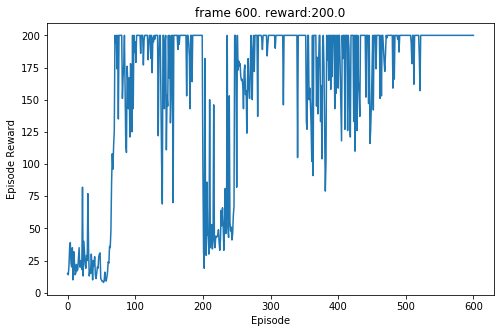

[TL] [*] Saving TL weights into sac_d/model_q_net1.npz
[TL] [*] Saved
[TL] [*] Saving TL weights into sac_d/model_q_net2.npz
[TL] [*] Saved
[TL] [*] Saving TL weights into sac_d/model_target_q_net1.npz
[TL] [*] Saved
[TL] [*] Saving TL weights into sac_d/model_target_q_net2.npz
[TL] [*] Saved
[TL] [*] Saving TL weights into sac_d/model_policy_net.npz
[TL] [*] Saved


In [15]:
# train
frame_idx = 0
rewards = []
t0 = time.time()
while frame_idx < max_frames:
    state = env.reset()
    state = state.astype(np.float32)
    episode_reward = 0
    if frame_idx < 1:
        print('intialize')
        # extra call 用来使内部func能够使用model.forward
        _ = sac_trainer.policy_net([state])


    while True:
        if frame_idx > explore_steps:
            action = sac_trainer.policy_net.get_action(state)
        else:
            action = sac_trainer.policy_net.sample_action()

        next_state, reward, done, _ = env.step(action)
        next_state = next_state.astype(np.float32)
        # env.render()
        done = 1 if done == True else 0

        replay_buffer.push(state, action, reward, next_state, done)

        state = next_state
        episode_reward += reward


        if len(replay_buffer) > batch_size:
            for i in range(update_itr):
                sac_trainer.update(batch_size, auto_entropy=AUTO_ENTROPY, 
                                   target_entropy=-np.log((1.0 / action_dim)) * 0.98)
        if done:
            break
    # episode = int(frame_idx / max_steps)  # 当前episode
    # all_episodes = int(max_frames / max_steps)  # 所有episode
    print('Episode:{}/{} | Episode Reward:{:.4f} | Running Time:{:.4f}' \
          .format(frame_idx, max_frames, episode_reward, time.time() - t0))
    rewards.append(episode_reward)
    if frame_idx % 100 == 0:
        plot(frame_idx, rewards)
    frame_idx += 1
sac_trainer.save_weights()

In [0]:
# test
frame_idx = 0
rewards = []
t0 = time.time()
sac_trainer.load_weights()
while frame_idx < test_frames:
    state = env.reset()
    state = state.astype(np.float32)
    episode_reward = 0
    if frame_idx < 1:
        print('intialize')
        # extra call 用来使内部func能够使用model.forward
        _ = sac_trainer.policy_net([state])

    while True:

        action = sac_trainer.policy_net.get_action(state)

        next_state, reward, done, _ = env.step(action)
        next_state = next_state.astype(np.float32)
        # env.render()
        done = 1 if done == True else 0


        state = next_state
        episode_reward += reward


        if done:
            break

    print('Episode:{}/{} | Episode Reward:{:.4f} | Running Time:{:.4f}' \
          .format(frame_idx, test_frames, episode_reward, time.time() - t0))
    rewards.append(episode_reward)
    frame_idx += 1

[TL] [*] Load model_q_net1.npz SUCCESS!
[TL] [*] Load model_q_net2.npz SUCCESS!
[TL] [*] Load model_target_q_net1.npz SUCCESS!
[TL] [*] Load model_target_q_net2.npz SUCCESS!
[TL] [*] Load model_policy_net.npz SUCCESS!
initialize
Episode:1/2 | Episode Reward:-117.6898 | Running Time:0.6417
Episode:2/2 | Episode Reward:-2.1611 | Running Time:1.2336
